<a href="https://colab.research.google.com/github/adrianbarrenada/APRENDIZAJE_AUTOMATICO_23_24/blob/main/GA1Lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 03 PRÁCTICA 1

Vamos a contruir un Decision Support System para el diagnostico de tumores en base a uno dataset que se nos ha proporcionado el cual mide distintas caracteristicas fisicas del tumor.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from google.colab import drive

**APARTADO 1**

En primer lugar cargamos los datos necesarios para el ejercicio, para esto tenenmos que guardar la base de datos en nuestro drive personal.

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/cancer.csv'

df = pd.read_csv(file_path, delimiter=r',', engine='python')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Una vez guardados pasamos con el preprocesamiento.

In [ ]:
print(df.head)

<bound method NDFrame.head of            id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0  

Mostramos unos pocos de nuestro dataframe para ver lo que recogen sus variables y que tipo de datos tiene cada una, nos llama bastante la atención la columna de unmaned la cual esta llena de valores NaN, vamos a comprobar si es la unica que contiene registros vacios y ha limpiar el dataframe para continuar con el proceso.

In [ ]:
# Contamos los NaN totales.
cantidad_nans_total = df.isna().sum().sum()

# Tambien lo de cada columna individualmente.
cantidad_nans_por_columna = df.isna().sum()

print("Cantidad total de NaN en el DataFrame:", cantidad_nans_total)
print("Cantidad de NaN por columna:")
print(cantidad_nans_por_columna)

Cantidad total de NaN en el DataFrame: 569
Cantidad de NaN por columna:
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         

Como sospechábamos todos los NaN se encontraban en esta columan por lo que la eliminamos de nuestro dataset.

In [ ]:
df_sin_nan = df.dropna(axis=1)

Seguimos con la limpieza de los datos calculando la matriz de correlacion de las variables para ver cuales dependen mucho de otras y podriamos omitir.

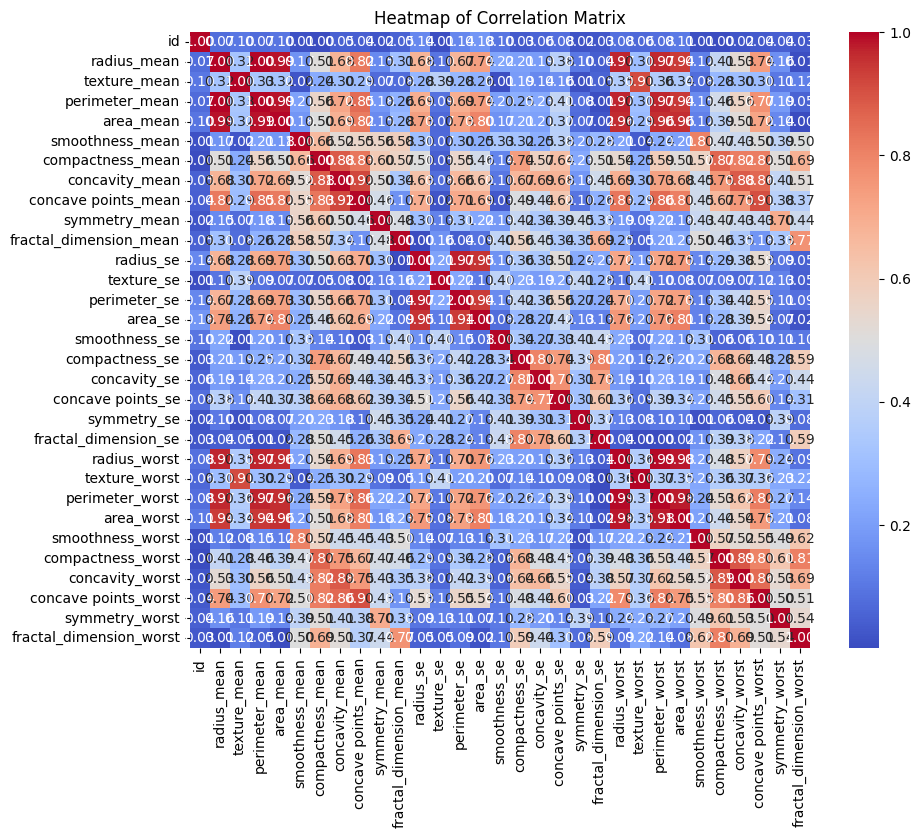

In [ ]:
numeric_cols = df_sin_nan.select_dtypes(include=[np.number]).columns
matriz_corr = df_sin_nan[numeric_cols].corr().abs()


plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
# Creamos un conjunto para almacenar los índices de las columnas a eliminar
columnas_a_eliminar = set()

for i in range(len(matriz_corr.columns)):
    for j in range(i + 1, len(matriz_corr.columns)):
        # Si la correlación entre las columnas es mayor que 0.9 y ninguna de las columnas ya ha sido marcada para ser eliminada
        if matriz_corr.iloc[i, j] > 0.9 and matriz_corr.columns[j] not in columnas_a_eliminar:
            columnas_a_eliminar.add(matriz_corr.columns[i])

# Eliminar las columnas del DataFrame
df_sin_correlaciones_altas = df_sin_nan.drop(columns=columnas_a_eliminar)

# Verificar las columnas restantes
print("Columnas eliminadas:", columnas_a_eliminar)

Columnas eliminadas: {'concave points_mean', 'radius_mean', 'texture_mean', 'perimeter_worst', 'perimeter_se', 'radius_worst', 'area_mean', 'perimeter_mean', 'concavity_mean', 'radius_se'}


Mostramos la nueva matriz de correlacion con las variables eliminadas para verificar que ahora no tenemos correlaciones altas.

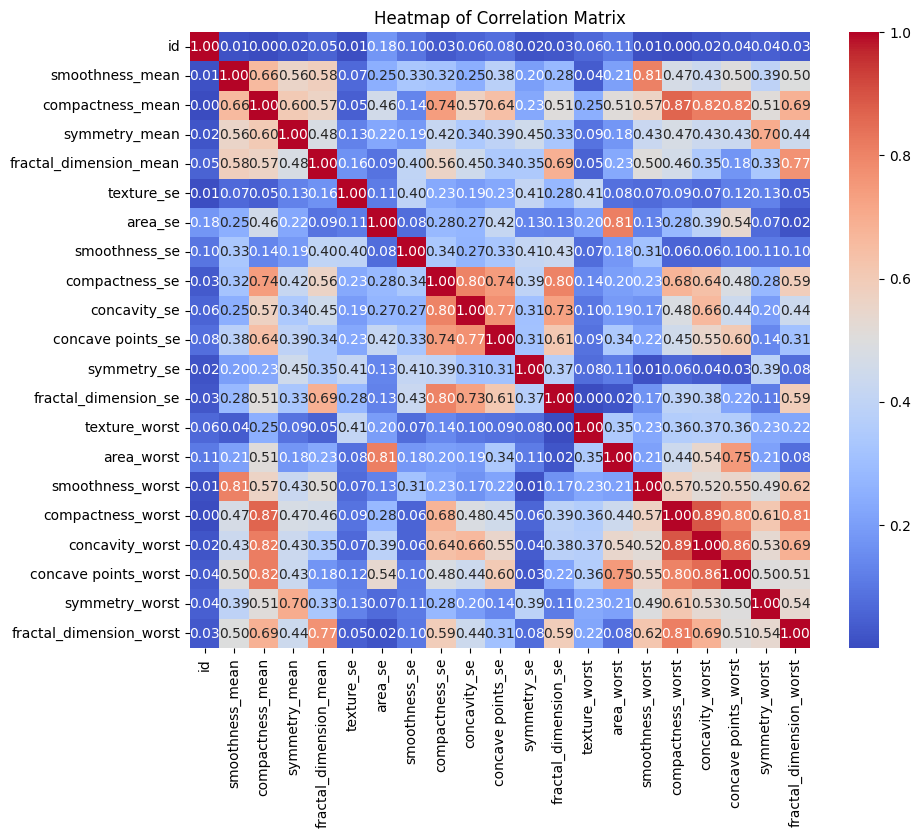

In [ ]:
numeric_cols = df_sin_correlaciones_altas.select_dtypes(include=[np.number]).columns
matriz_corr = df_sin_correlaciones_altas[numeric_cols].corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

Ahora pasamos a categorizar en tres valores los datos que midan el área, el diámetro y la compacidad.

-Para el area queda la variable 'area_se' y 'area_worst'.

-Para el diametro no se ha encontrado ninguna variable que tenga en cuenta este parametro.

-Para la compacidad vamos a transformar 'compactness_se','compactness_worst','compactness_mean'.

In [ ]:
df_sin_correlaciones_altas['area_se'] = pd.cut(df_sin_correlaciones_altas['area_se'], bins=3, labels=[1, 2, 3])
df_sin_correlaciones_altas['area_worst'] = pd.cut(df_sin_correlaciones_altas['area_worst'], bins=3, labels=[1, 2, 3])

df_sin_correlaciones_altas['compactness_se'] = pd.cut(df_sin_correlaciones_altas['compactness_se'], bins=3, labels=[1, 2, 3])
df_sin_correlaciones_altas['compactness_worst'] = pd.cut(df_sin_correlaciones_altas['compactness_worst'], bins=3, labels=[1, 2, 3])
df_sin_correlaciones_altas['compactness_mean'] = pd.cut(df_sin_correlaciones_altas['compactness_mean'], bins=3, labels=[1, 2, 3])

Con los datos ya comepletamente limpios y transoformados vamos a seleccionar 5 individuos del dataset para utilizarlos posteriormente en el apartado 5.

In [ ]:
# Seleccionamos 5 filas aleatorias.
individuos_aleatorios = df_sin_correlaciones_altas.sample(n=5, random_state=13)

# Eliminamos estas filas del DataFrame original.
df_Limpio = df_sin_correlaciones_altas.drop(individuos_aleatorios.index)

**APARTADOS 2 Y 3**

Ahora vamos a hacer los clasificadores con la funcion 'DecisionTreeClassifier' de la libreria scikitlearn, esta funcion se utiliza para realizar clasificaciones basadas en un modelo de árbol de decisión.

 Los árboles de decisión son métodos no paramétricos y supervisados que modelan las decisiones y sus posibles consecuencias como un árbol, incluyendo las probabilidades de resultados, los costos de recursos y la utilidad. Estos son faciles de interpretar y representar.

 Vamos a crear dos modelos basandonos en el criterio que mide la calidad de una división, el primero es "gini" y el segundo "entropy" . Gini es típicamente más rápido de calcular y es el predeterminado, mientras que la entropía puede producir árboles más balanceados.

Separamos la la variable objetivo que queremos predecir de los demás datos t les asignamos la varibales y,X respestivamente, además realizamos una partición de los datos al 80/20 para tener un conjunto de datos de entrenamiento y un cojunto de datos de test con los que valorar la efecitividad de nuestros modelos y determinar cual es el mejor.

In [ ]:
y = df_Limpio['diagnosis']
X = df_Limpio.drop(['diagnosis', 'id'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

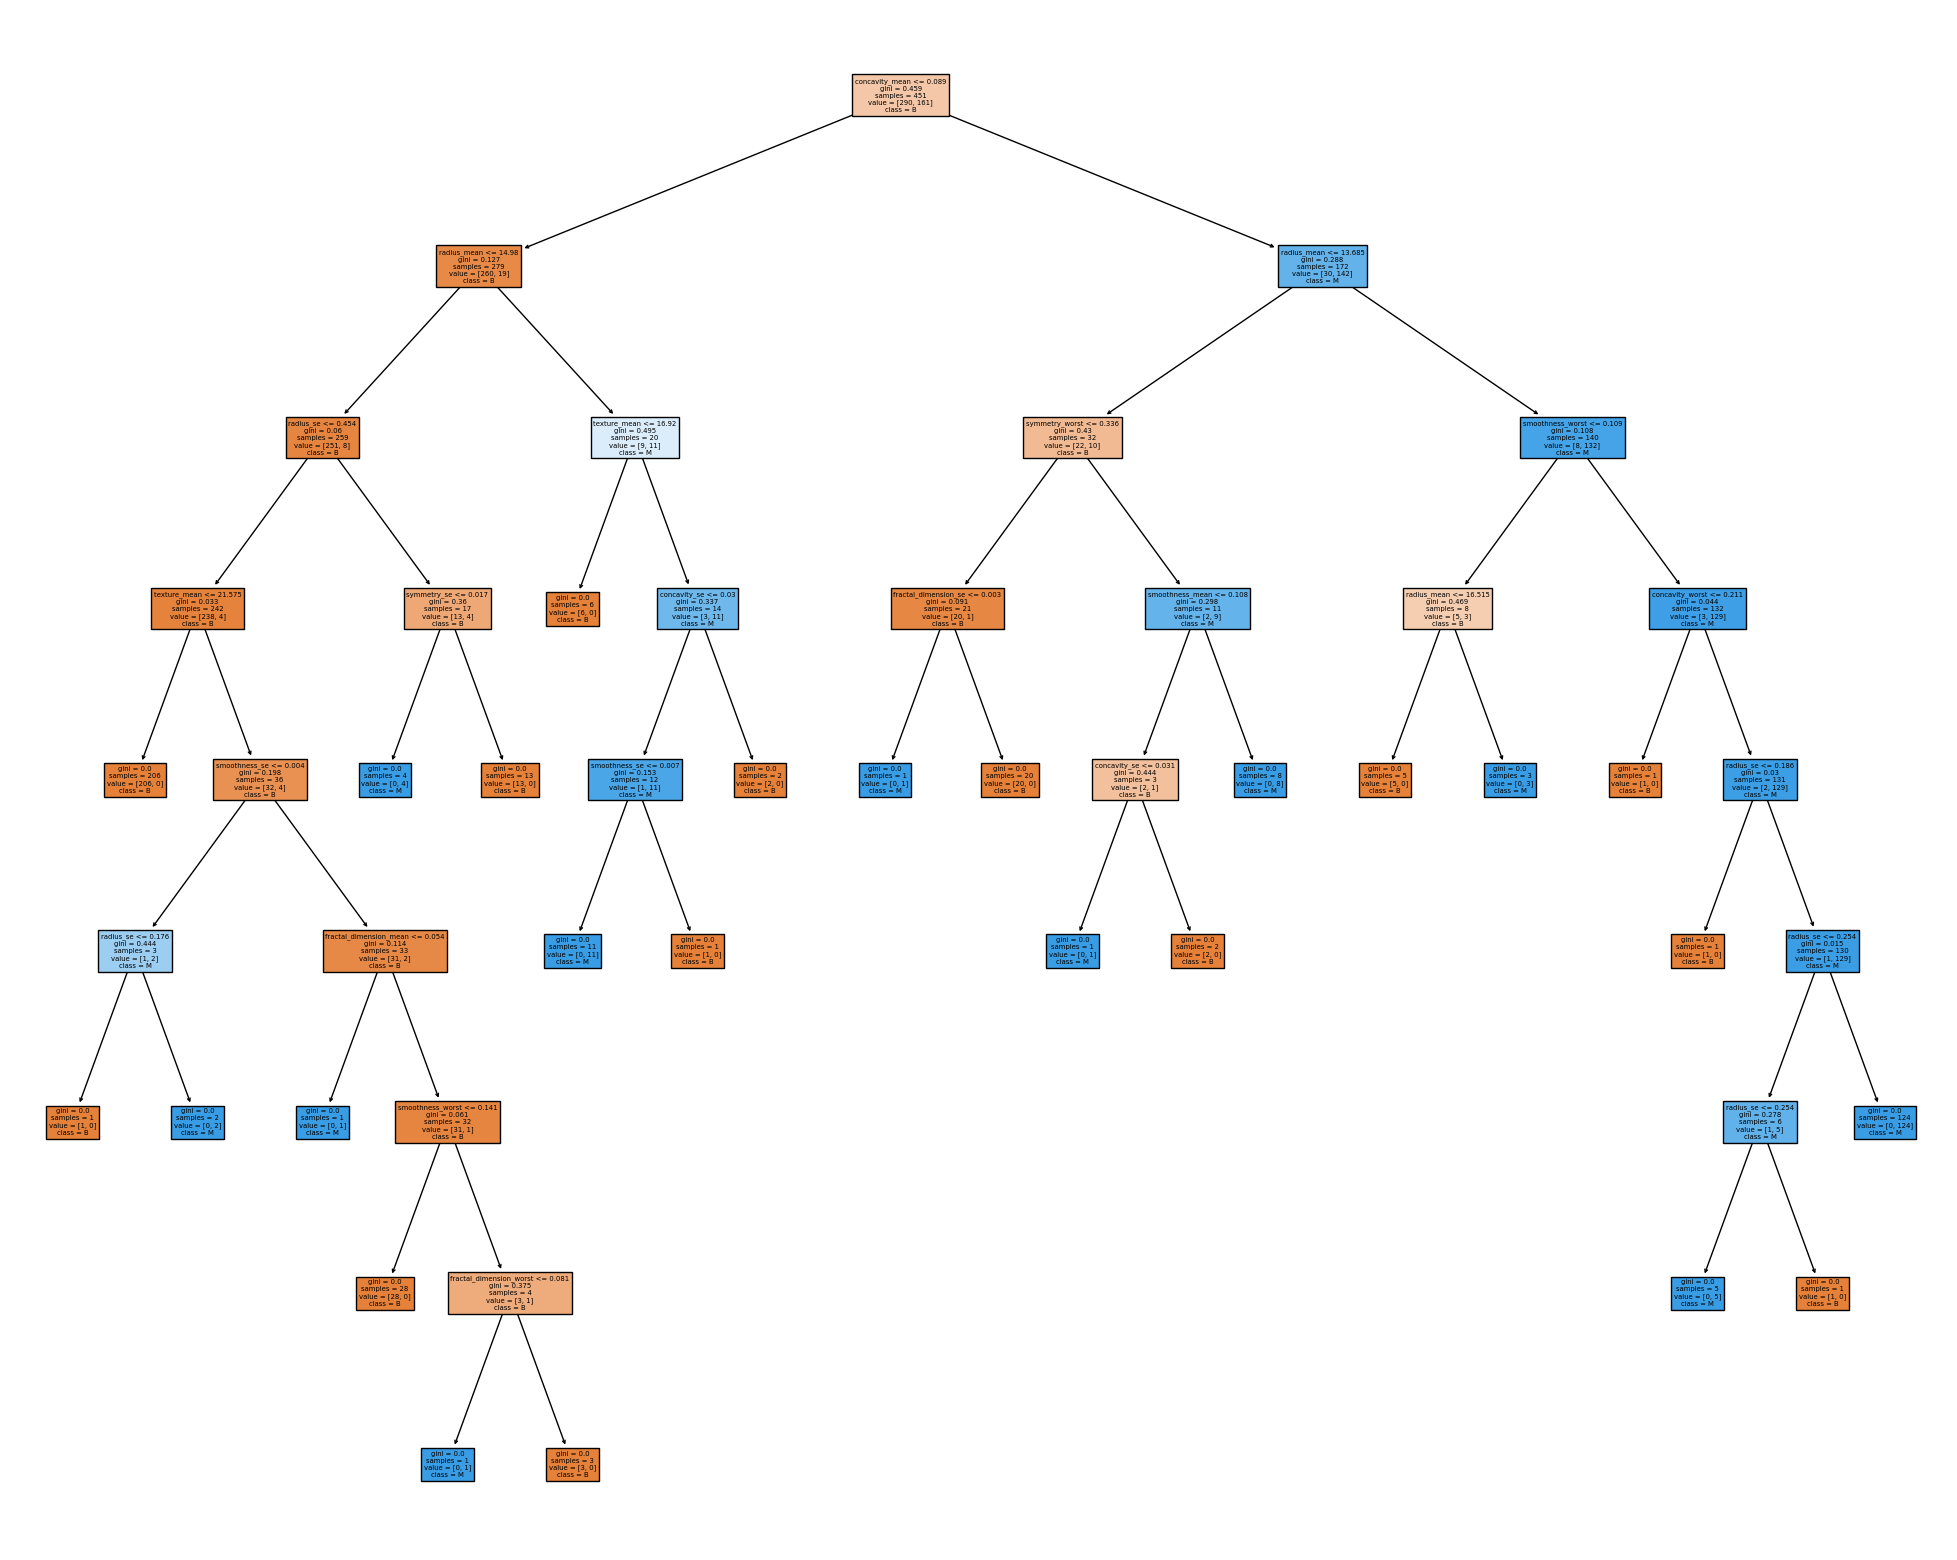

Precisión del modelo: 0.911504424778761
Error global del modelo: 0.08849557522123896


In [ ]:
# Sacamos los nombres de las variables y de las clases
feature_names = X.columns.tolist()
class_names = sorted(y.unique())


arbol_gini = DecisionTreeClassifier(criterion = 'gini')
arbol_gini.fit(X_train, y_train)


# Graficamos el árbol de decisión
plt.figure(figsize=(25, 20))
plot_tree(arbol_gini, filled=True, feature_names = feature_names, class_names= class_names )
plt.show()



# Calculamos ahora la precisión del modelo
y_pred = arbol_gini.predict(X_test)

# Calculamos la precisión del modelo
precision = accuracy_score(y_test, y_pred)

# Calculamos el error global (1 - precisión)
error_global = 1 - precision

print("Precisión del modelo:", precision)
print("Error global del modelo:", error_global)

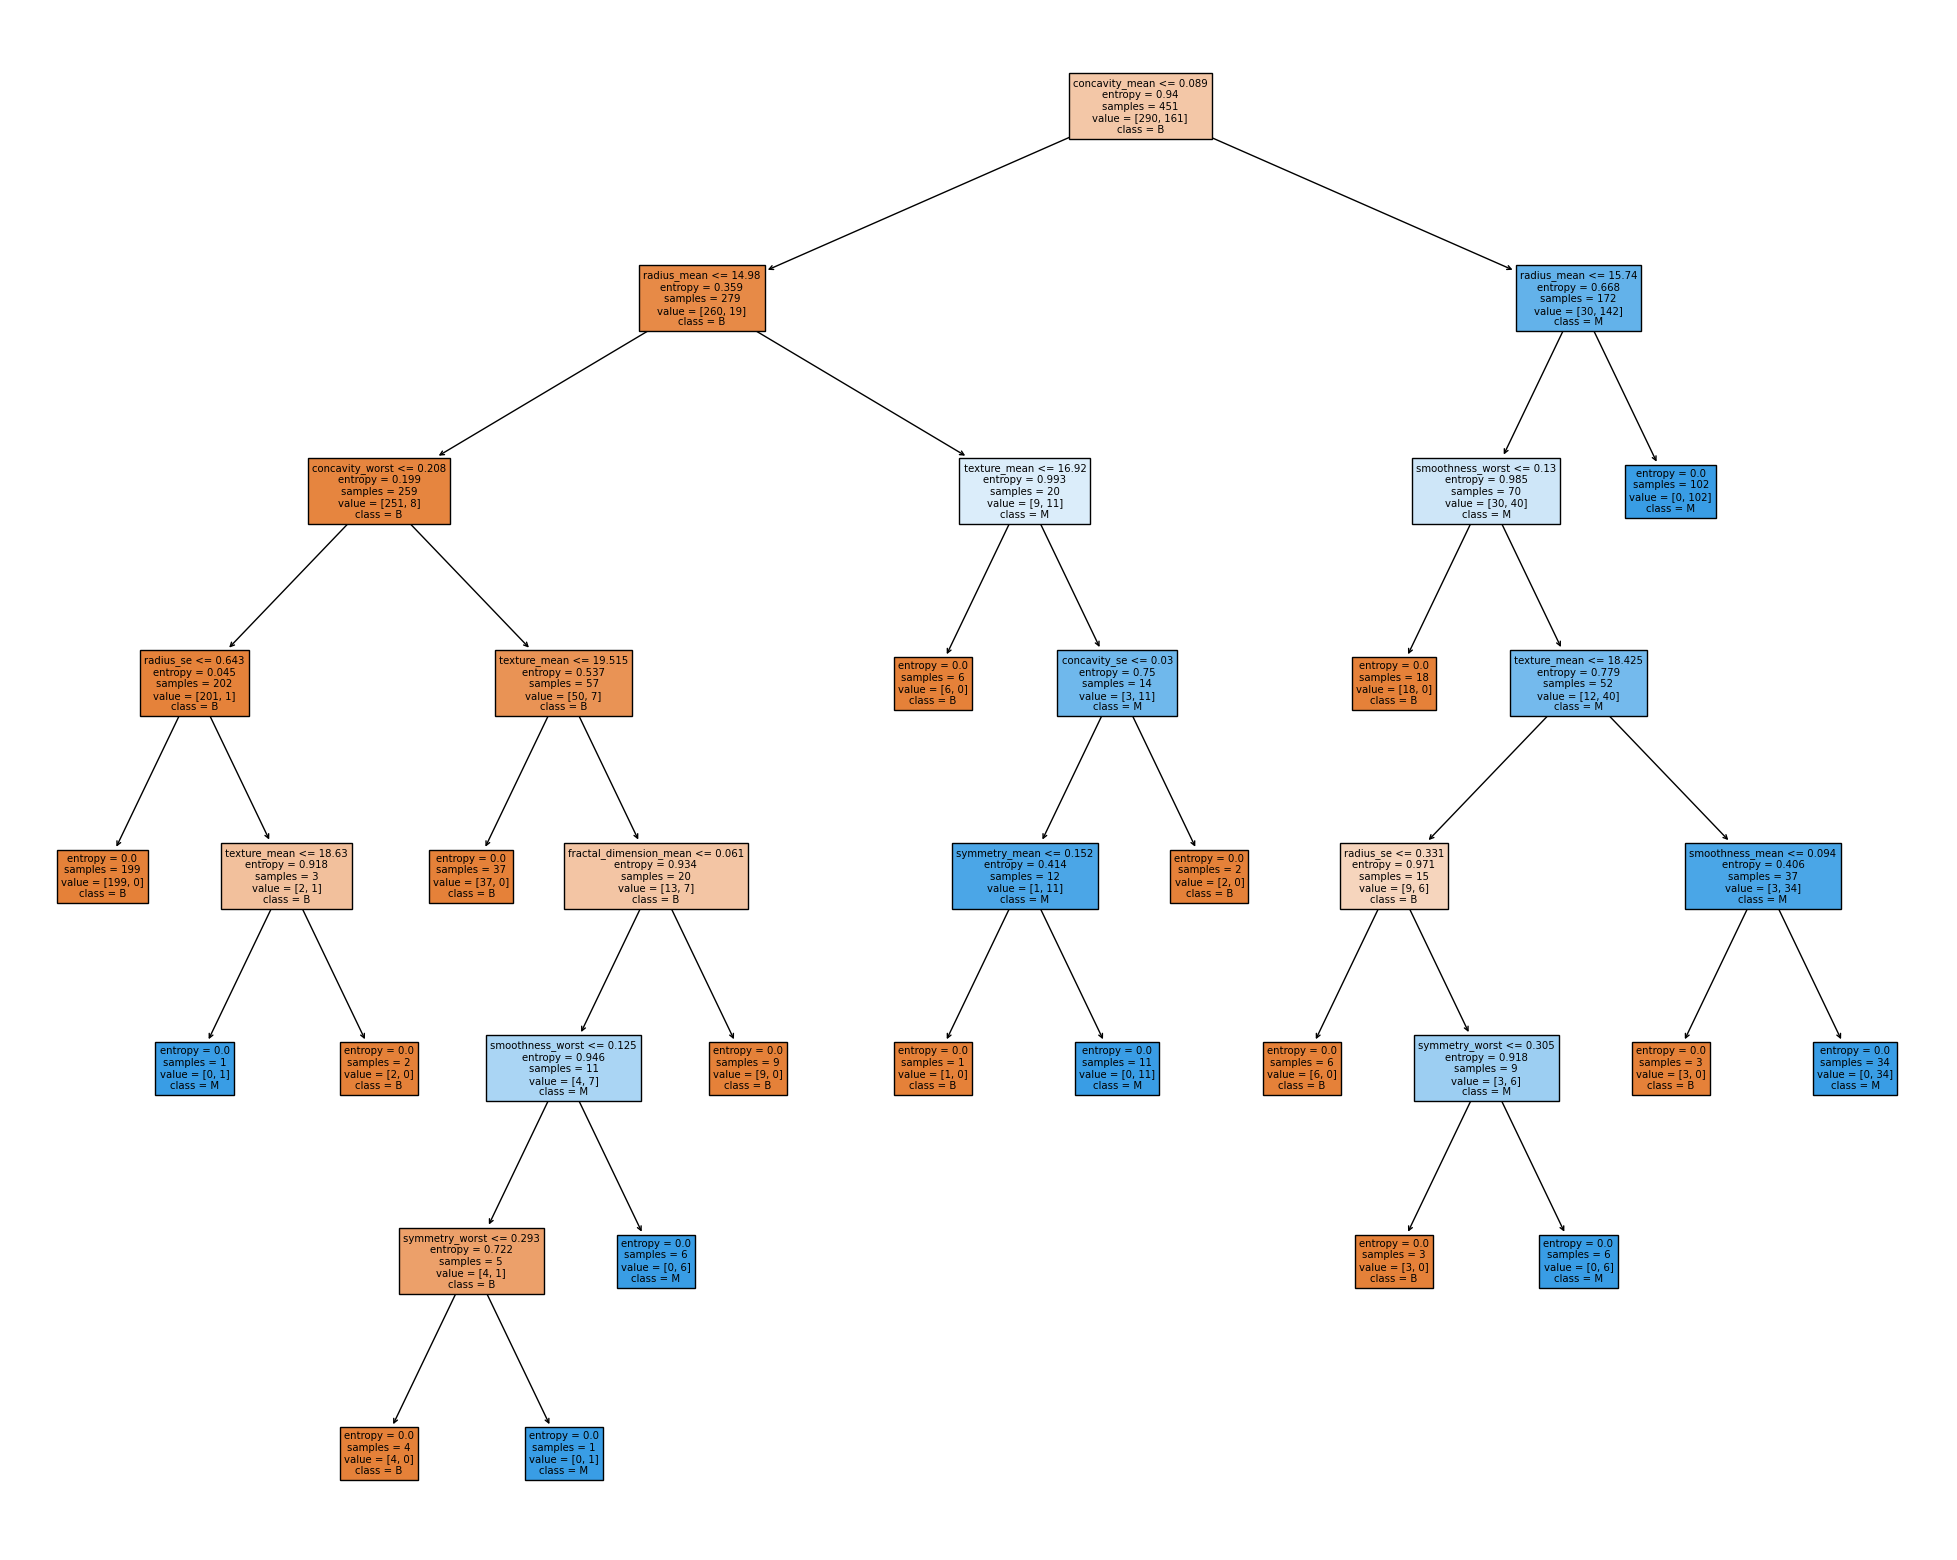

Precisión del modelo: 0.9557522123893806
Error global del modelo: 0.04424778761061943


In [ ]:
# Ahora con el criterio de entropia
arbol_entropia = DecisionTreeClassifier(criterion = 'entropy')
arbol_entropia.fit(X_train, y_train)


# Graficamos
plt.figure(figsize=(25, 20))
plot_tree(arbol_entropia, class_names=class_names ,filled=True, feature_names= feature_names)
plt.show()


y_pred = arbol_entropia.predict(X_test)

# Calculamos la precisión del modelo
precision = accuracy_score(y_test, y_pred)

# Calculamos el error global (1 - precisión)
error_global = 1 - precision

print("Precisión del modelo:", precision)
print("Error global del modelo:", error_global)

Las precisiones de los modelos suelen cambiar con cada ejecucion del codigo debido a que este tiene algunos procesos aleatorios que producen pequeños cambios, lo que más se ha repetido es que la precisión del modelo 'arbol_entropia' sea el mas preciso, con un exito clasificando los datos de test que suele superar el 90% por ciendo en la gran mayoria de intentos

**APARTADO 4**


**Generalizar** significa crear reglas que aplican a un amplio rango de casos. Una regla que generaliza:

Se aplica a muchos ejemplos diferentes.
Es menos detallada y utiliza características más amplias.
Tiene una mayor probabilidad de aplicar correctamente a casos nuevos y no vistos durante el entrenamiento.
Puede ser demasiado simplista y puede no capturar las complejidades o las excepciones específicas de algunos casos.

**Especializar** significa crear reglas que son aplicables a un conjunto muy específico de circunstancias. Una regla que se especializa:

Se aplica a un pequeño grupo de ejemplos con características muy específicas.
Es más detallada y utiliza criterios más restrictivos.
Puede ser muy precisa para los casos a los que se aplica, pero tiene un rango limitado de aplicación.
Puede no ser útil para casos nuevos que no cumplen con los criterios específicos, incluso si son ligeramente diferentes.

aplicado a nuestros arboles de clasificacion las que mas generalizen serán las que se encuentren mas arriba debido a que estas tienen muy pocas restriciones y se pueden usar para clasificar de una manera relativamente efecriva una gran cantidad de datos. Las reglas mas especializadas serian las más profundas las que no se pueden utilizar con la gran mayoria de los datos pero los que coinciden perfectamente con la gran cantidad de restricciones que presentan tiene una probilidad muy alta de acertar la predicción.



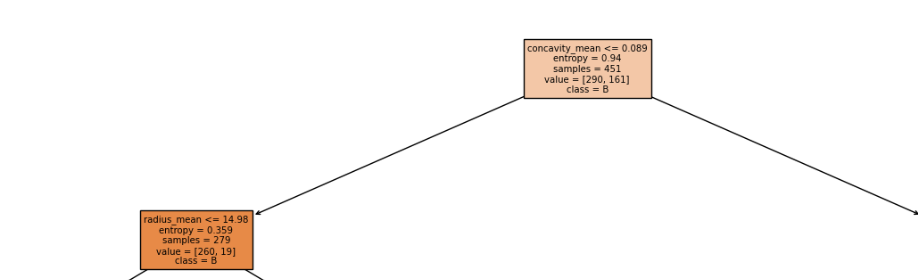

Estas serian las dos reglas más generales de nuestro modelo debido a que cuentan con el valor de sample mas alto y tienen solamente una y dos restricciones respectivamente.

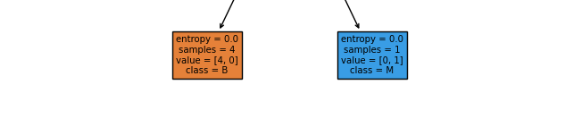

Estas dos serían las reglas más especializadas de nuestro modelo, tiene la mayor cantidad de restricciones pasando por muchos nodos hasta determinar su clase, todos los casos que cumplen estas restricciones pertenecen unicamente a una clase




**APARTADO 5**

Vamos a usar el clasificador que mejor rendimiento nos ha dado para clasificar 5 individuos los cuales hemos separado del dataset al terminar el preprocesado

In [ ]:
X = individuos_aleatorios.drop(['diagnosis', 'id'], axis=1)
y_verdadero = individuos_aleatorios['diagnosis'] # Las etiquetas verdaderas para comparar con las predicciones.

# Hacemos las predicciones con el arbol que mejor resultado nos ha dado.
y_prediccion = arbol_entropia.predict(X)

# Mostramos las predicciones y los valores verdaderos.
for i in range(len(y_prediccion)):
    print(f"La predicción  para el individuo con id: {individuos_aleatorios['id'].iloc[i]} es: {y_prediccion[i]} , su Valor verdadero es: {y_verdadero.iloc[i]}")

La predicción  para el individuo con id: 8810987 es: B , su Valor verdadero es: M
La predicción  para el individuo con id: 894855 es: B , su Valor verdadero es: B
La predicción  para el individuo con id: 906290 es: B , su Valor verdadero es: B
La predicción  para el individuo con id: 85638502 es: B , su Valor verdadero es: M
La predicción  para el individuo con id: 89143601 es: B , su Valor verdadero es: B


Como podemos ver las predicciones de estos individuos es en su mayoria correctas pero tienen un margen de error, se ha seleccionado previamente una semilla especifica para que algunas de las predicciones sean erroneas y poder ver que los sistemas de soporte a decisiones no son perfectos y que si este fuese un caso real una persona habría sido diagnosticada erroneamente, si bien su precision es bastante alta y nos pueden servir para procesar grandes cantidades de datos sobre muchas variables y sacar reglas que suelen estar acerdatas, estos no pueden ser nunca el unico factor para determinar decisiones tan importantes como el diagnostico de un tumor.

# LAB 03 PRÁCTICA 2

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 30.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/TCGA.csv' #poner ruta de guardado en drive

data = pd.read_csv(file_path, delimiter=r',', engine='python')

Mounted at /content/drive


Veamos que aspecto tiene nuestra base de datos:

In [3]:
print(data.head())

  Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
0   LGG  TCGA-LGG  TCGA-DU-8164    Male  51 years 108 days   
1   LGG  TCGA-LGG  TCGA-QH-A6CY    Male  38 years 261 days   
2   LGG  TCGA-LGG  TCGA-HW-A5KM    Male   35 years 62 days   
3   LGG  TCGA-LGG  TCGA-E1-A7YE  Female  32 years 283 days   
4   LGG  TCGA-LGG  TCGA-S9-A6WG    Male  31 years 187 days   

         Primary_Diagnosis   Race     IDH1         TP53         ATRX  ...  \
0   Oligodendroglioma, NOS  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1             Mixed glioma  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
2         Astrocytoma, NOS  white  MUTATED      MUTATED      MUTATED  ...   
3  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   
4  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   

         FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1  NOT_MUTATED  NOT_MUTA

Vemos que casi todos los valores son binarios: bien MUTATED o bien NOT_MUTATED. Sin embargo, también hay valores que tienen más de dos categorías, como Primary_Diagnosis o Race. Vemos que hay una variable continua (a parte de Case_ID que es el identificador de los pacientes), Age_at_diagnosis.

In [4]:
len(data)

862

Para ver la forma de los datos y cuántas categorías tienen los atributos, vamos a representarlos con histogramas, de manera que veamos como se distribuyen:

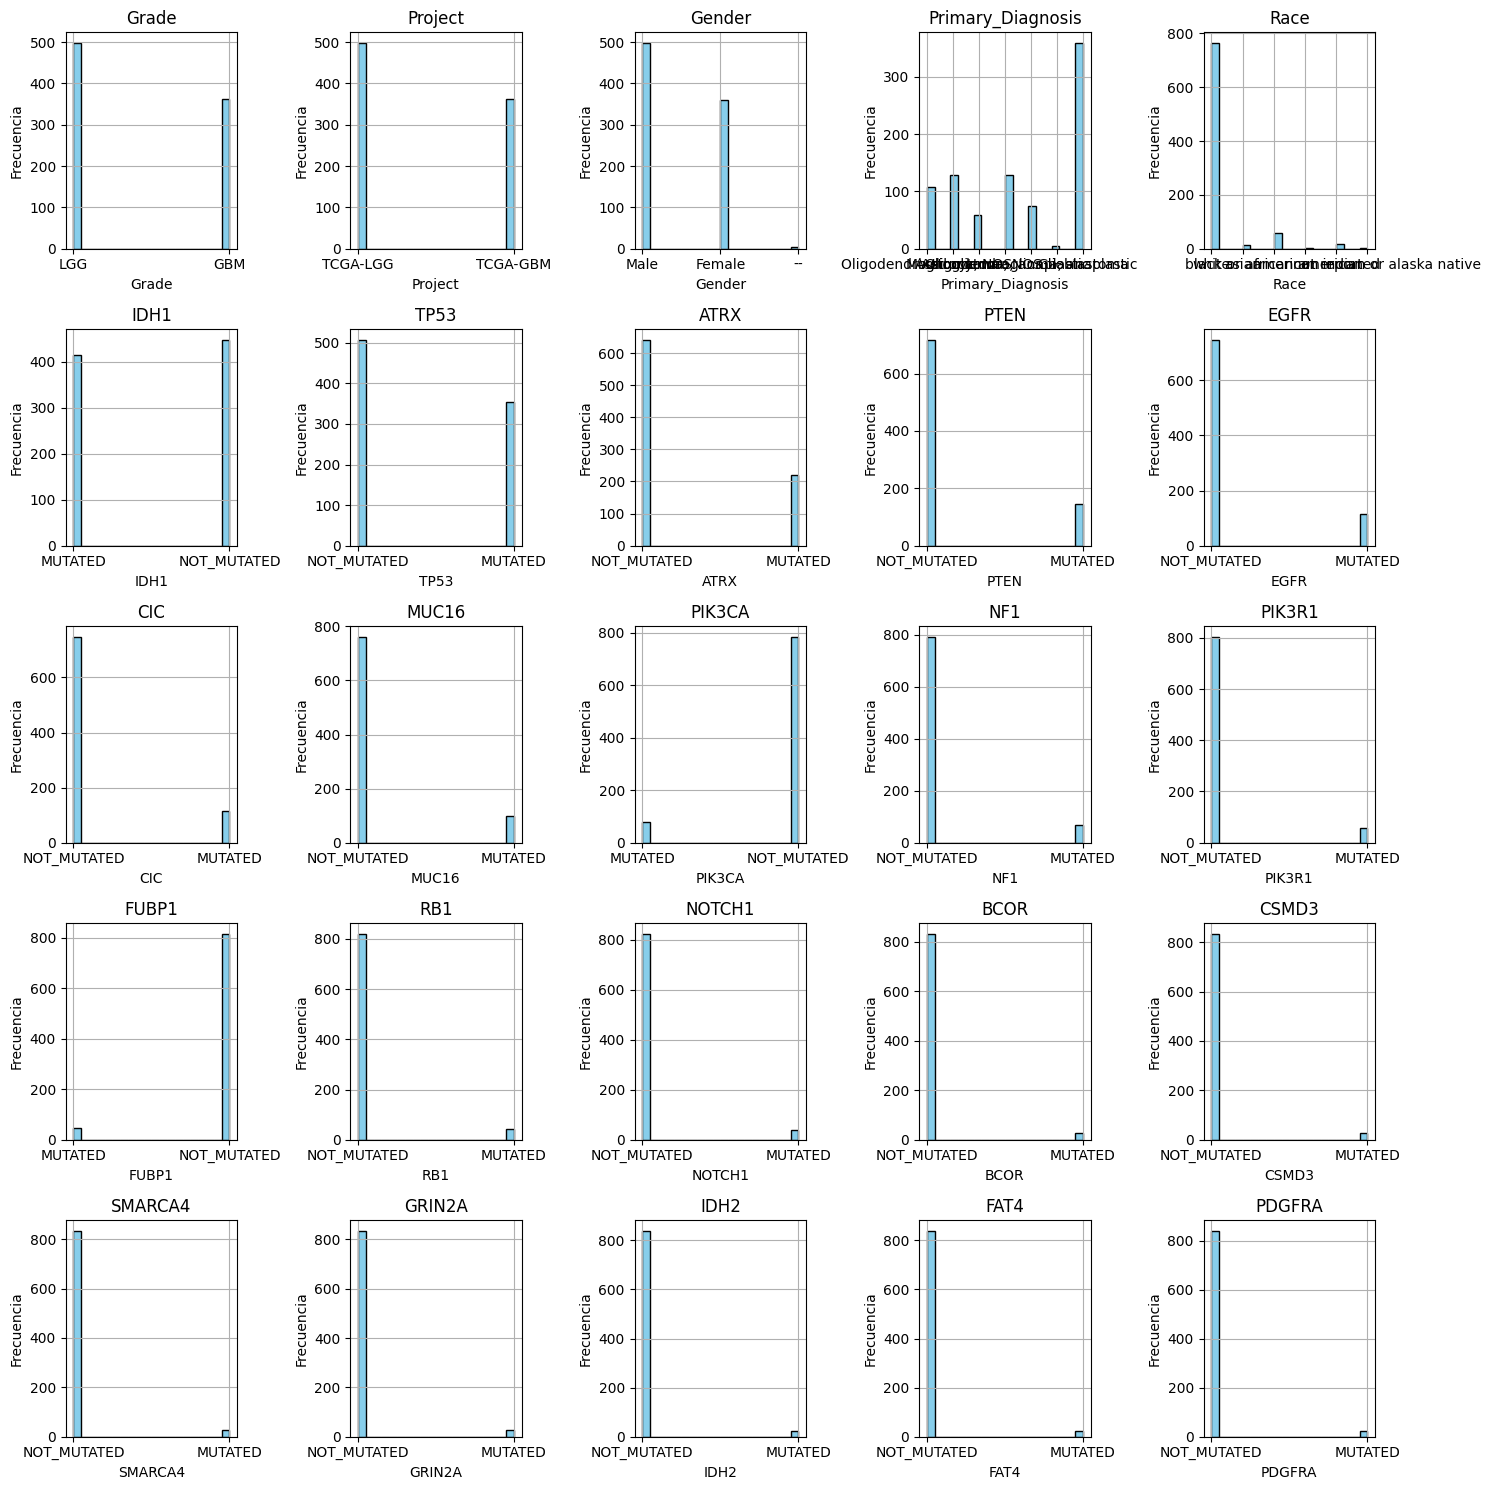

In [5]:
import math

#Extraemos los nombres de las columnas excepto 'id' y 'diagnosis'
atributos = [col for col in data.columns if col not in ['Case_ID', 'Age_at_diagnosis']]

#Calculamos el número de filas y columnas para los subplots
num_atributos = len(atributos)
num_filas = math.ceil(num_atributos / 5)
num_columnas = min(num_atributos, 5)

#Configuramos la figura y los subplots
fig, axs = plt.subplots(nrows=num_filas, ncols=num_columnas, figsize=(15, 3*num_filas))

#Iteramos sobre cada atributo y lo graficamos en su respectivo subplot
for i, atributo in enumerate(atributos):
    row = i // num_columnas
    col = i % num_columnas
    axs[row, col].hist(data[atributo], bins=20, color='skyblue', edgecolor='black')
    axs[row, col].set_title(atributo)
    axs[row, col].set_xlabel(atributo)
    axs[row, col].set_ylabel('Frecuencia')
    axs[row, col].grid(True)

#Ajustamos el diseño de los subplots
plt.tight_layout()

#Mostramos la figura
plt.show()

In [6]:
pip install stemgraphic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=feec581c265d2bc46465c183f3aafa8c931122f2ca2819ff92ba417f2257b5b8
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


Vamos a graficar la edad de los clientes con un diagrama de tallos y hojas:

In [7]:
#Primero, extraemos los componentes de edad
data['Age_years'] = data['Age_at_diagnosis'].str.extract(r'(\d+) years').astype(float)
data['Age_months'] = data['Age_at_diagnosis'].str.extract(r'(\d+) months').astype(float).fillna(0)
data['Age_days'] = data['Age_at_diagnosis'].str.extract(r'(\d+) days').astype(float).fillna(0)

#Luego, convertimos todo a años dividiendo los meses entre 12 y los días entre 365
data['Age_in_years'] = data['Age_years'] + data['Age_months'] / 12 + data['Age_days'] / 365

#Eliminamos las columnas auxiliares
data.drop(['Age_years', 'Age_months', 'Age_days'], axis=1, inplace=True)

data_sorted = data.sort_values('Age_in_years')

#Generamos el diagrama de tallos y hojas
def stem_and_leaf(data):
    stems = data // 10
    leafs = data % 10
    return stems, leafs

data_sorted['Stems'], data_sorted['Leafs'] = stem_and_leaf(data_sorted['Age_in_years'] * 10)

#Imprimimos el diagrama
for stem, leafs in data_sorted.groupby('Stems')['Leafs']:
    print(f"{int(stem):2d} | {' '.join(map(str, leafs.values.astype(int)))}")

14 | 4
17 | 7
19 | 1
20 | 2 2 3 7 8 9
21 | 6 7 7 7
22 | 0 5 6 8 8
23 | 0 2 3 4 8 9
24 | 1 1 2 4 4 4 6 7
25 | 1 2 2 2 5 5 6 6 7 8
26 | 1 1 2 3 4 5
27 | 0 1 4 6 6 7 8 8 8
28 | 0 2 3 5 5 6 9
29 | 0 1 2 2 3 4 5 5 6 6 6 7 8 9
30 | 0 0 1 2 3 3 3 4 4 6 6 7 7 8 8 9 9 9 9 9 9
31 | 0 0 0 0 0 2 4 4 5 5 5 7 7 8 8 9 9 9
32 | 1 1 2 3 3 3 4 4 4 4 4 5 7 7
33 | 0 1 1 1 2 2 2 4 5 5 5 6 6 7 9 9 9 9 9 9
34 | 0 1 1 3 3 3 4 4 5 5 5 6 7 8 9 9
35 | 0 1 1 1 1 1 1 1 1 1 2 5 6 8 9
36 | 1 1 1 2 2 2 4 5 5 6 6 6 7 8 8 8 9 9
37 | 0 0 1 1 2 2 2 2 2 4 4 4 6 7
38 | 0 0 0 0 0 1 2 2 3 3 3 3 5 5 5 5 6 7 7 8 8 8 8 9
39 | 0 0 1 1 1 3 3 4 4 4 5 6 7 7 8 8 9 9
40 | 0 1 1 1 1 2 5 5 5 6 7 8 8 8 8 8 9
41 | 0 1 1 2 2 3 3 3 4 5 6 6 8 8
42 | 0 0 2 3 4 6 6 7 8 8
43 | 0 3 3 3 3 4 5 6 6 6 7 7 8 8 9 9
44 | 0 1 1 2 2 3 3 5 5 5 6 6 6 6 7 9
45 | 0 0 2 3 3 6 6 6 7 8 8 9
46 | 1 2 3 3 4 6 6 9 9
47 | 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 8 9 9 9
48 | 2 2 3 3 4 4 5 5 5 6 6 7 8 8 9 9 9 9 9
49 | 0 4 4 5 6 7 7 7 8 8 8 8 8 9 9
50 | 0 1 2 3 4 4 4 4 4 6 6 

In [8]:
import re

#Definimos una función para extraer los años de la columna 'Age_at_diagnosis'
def extract_years(age_string):
    #Se buscará un grupo de números seguido de 'years'
    match = re.search(r'(\d+) years', age_string)
    if match:
        #Si se encuentra una coincidencia, se devuelve el número encontrado
        return int(match.group(1))
    else:
        #Si no, se devuelve NaN
        return None

#Aplica la función a la columna 'Age_at_diagnosis' y guarda los resultados en una nueva columna 'Years_at_diagnosis'
data['Years_at_diagnosis'] = data['Age_at_diagnosis'].apply(extract_years)
#Eliminamos la columna 'Age_at_diagnosis' de nuestros datos
data.drop(columns=['Age_at_diagnosis'], inplace=True)
data.drop(columns=['Age_in_years'], inplace=True)

print(data.head())

  Grade   Project       Case_ID  Gender        Primary_Diagnosis   Race  \
0   LGG  TCGA-LGG  TCGA-DU-8164    Male   Oligodendroglioma, NOS  white   
1   LGG  TCGA-LGG  TCGA-QH-A6CY    Male             Mixed glioma  white   
2   LGG  TCGA-LGG  TCGA-HW-A5KM    Male         Astrocytoma, NOS  white   
3   LGG  TCGA-LGG  TCGA-E1-A7YE  Female  Astrocytoma, anaplastic  white   
4   LGG  TCGA-LGG  TCGA-S9-A6WG    Male  Astrocytoma, anaplastic  white   

      IDH1         TP53         ATRX         PTEN  ...          RB1  \
0  MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
1  MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
2  MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
3  MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   
4  MUTATED      MUTATED      MUTATED  NOT_MUTATED  ...  NOT_MUTATED   

        NOTCH1         BCOR        CSMD3      SMARCA4       GRIN2A  \
0  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATE

Como en los histogramas representados anteriormente no se aprecian claramente los valores que pueden tomar algunos atributos ya que algunos nombres son muy largos, vamos a mostrarlo por separado:

In [9]:
valores_distintos_1 = data['Primary_Diagnosis'].unique()
valores_distintos_2 = data['Gender'].unique()
valores_distintos_3_1 = data['Race'].unique()

#Imprimimos los valores únicos
print(valores_distintos_1)
print(valores_distintos_2)
print(valores_distintos_3_1)

['Oligodendroglioma, NOS' 'Mixed glioma' 'Astrocytoma, NOS'
 'Astrocytoma, anaplastic' 'Oligodendroglioma, anaplastic' '--'
 'Glioblastoma']
['Male' 'Female' '--']
['white' 'asian' 'black or african american' '--' 'not reported'
 'american indian or alaska native']


Vemos que hay valores erróneos (--). Para ver qué se hace con ellos, vamos a ver cuántos hay:

In [10]:
conteo_1 = (data['Primary_Diagnosis'] == '--').sum()
conteo_2 = (data['Gender'] == '--').sum()
conteo_3_1 = (data['Race'] == '--').sum()
conteo_3_2 = (data['Race'] == 'not reported').sum()
#Imprimir el resultado
print("Número de filas con '--' en Primary_Diagnosis ->", conteo_1)
print("Número de filas con '--' en Gender ->", conteo_2)
print("Número de filas con '--' en Race->", conteo_3_1)
print("Número de filas con 'not reported' en Race->", conteo_3_2)

Número de filas con '--' en Primary_Diagnosis -> 4
Número de filas con '--' en Gender -> 4
Número de filas con '--' en Race-> 4
Número de filas con 'not reported' en Race-> 18


Vamos a eliminar los registros que tengan '--', ya que no son demasiados

In [11]:
#Utilizamos loc para filtrar los valores "--" y eliminar las filas correspondientes
data = data.loc[data['Primary_Diagnosis'] != '--']
data = data.loc[data['Gender'] != '--']
data = data.loc[data['Race'] != '--']
cont_1 = (data['Primary_Diagnosis'] == '--').sum()
cont_2 = (data['Gender'] == '--').sum()
cont_3_1 = (data['Race'] == '--').sum()
cont_3_2 = (data['Race'] == 'not reported').sum()
print("Número de filas con '--' en Primary_Diagnosis ->", cont_1)
print("Número de filas con '--' en Gender ->", cont_2)
print("Número de filas con '--' en Race ->", cont_3_1)
print("Número de filas con 'not reported' en Race->", cont_3_2)

Número de filas con '--' en Primary_Diagnosis -> 0
Número de filas con '--' en Gender -> 0
Número de filas con '--' en Race -> 0
Número de filas con 'not reported' en Race-> 18


Vamos a ver qué valores NaN hay en nuestros datos:

In [12]:
valores_nulos_por_columna = data.isna().sum()

total_valores_nulos = valores_nulos_por_columna.sum()

#Imprimimos el número de valores NaN por columna y el total de valores NaN en la base de datos
print("Número de valores NaN por columna:")
print(valores_nulos_por_columna)
print("\nTotal de valores NaN en la base de datos:", total_valores_nulos)

Número de valores NaN por columna:
Grade                 0
Project               0
Case_ID               0
Gender                0
Primary_Diagnosis     0
Race                  0
IDH1                  0
TP53                  0
ATRX                  0
PTEN                  0
EGFR                  0
CIC                   0
MUC16                 0
PIK3CA                0
NF1                   0
PIK3R1                0
FUBP1                 0
RB1                   0
NOTCH1                0
BCOR                  0
CSMD3                 0
SMARCA4               0
GRIN2A                0
IDH2                  0
FAT4                  0
PDGFRA                0
Years_at_diagnosis    1
dtype: int64

Total de valores NaN en la base de datos: 1


Vemos que es 1, y que se encuentra en el atributo de la edad de los clientes, vamos a eliminarlo:

In [13]:
data = data.dropna(subset=['Years_at_diagnosis'])

In [14]:
valores_nulos_por_columna = data.isna().sum()

total_valores_nulos = valores_nulos_por_columna.sum()

#Imprimimos el número de valores NaN por columna y el total de valores NaN en la base de datos
print("Número de valores NaN por columna:")
print(valores_nulos_por_columna)
print("\nTotal de valores NaN en la base de datos:", total_valores_nulos)

Número de valores NaN por columna:
Grade                 0
Project               0
Case_ID               0
Gender                0
Primary_Diagnosis     0
Race                  0
IDH1                  0
TP53                  0
ATRX                  0
PTEN                  0
EGFR                  0
CIC                   0
MUC16                 0
PIK3CA                0
NF1                   0
PIK3R1                0
FUBP1                 0
RB1                   0
NOTCH1                0
BCOR                  0
CSMD3                 0
SMARCA4               0
GRIN2A                0
IDH2                  0
FAT4                  0
PDGFRA                0
Years_at_diagnosis    0
dtype: int64

Total de valores NaN en la base de datos: 0


In [15]:
len(data)

857

In [16]:
#Reemplazamos los valores existentes por 1 o 0
data['Grade'] = data['Grade'].replace({'LGG': 0, 'GBM': 1})
data['Project'] = data['Project'].replace({'TCGA-LGG': 0, 'TCGA-GBM': 1})
data['Gender'] = data['Gender'].replace({'Male': 0, 'Female': 1})
data['Primary_Diagnosis'] = data['Primary_Diagnosis'].replace({'Oligodendroglioma, NOS': 0, 'Mixed glioma': 1, 'Astrocytoma, NOS' : 2,
 'Astrocytoma, anaplastic': 3, 'Oligodendroglioma, anaplastic': 4, 'Glioblastoma': 5})
data['Race'] = data['Race'].replace({'white': 0, 'asian': 1, 'black or african american': 2 , 'not reported':3,
 'american indian or alaska native': 4})

In [17]:
data = data.replace({'MUTATED': 1, 'NOT_MUTATED': 0})
print(data.head())

   Grade  Project       Case_ID  Gender  Primary_Diagnosis  Race  IDH1  TP53  \
0      0        0  TCGA-DU-8164       0                  0     0     1     0   
1      0        0  TCGA-QH-A6CY       0                  1     0     1     0   
2      0        0  TCGA-HW-A5KM       0                  2     0     1     1   
3      0        0  TCGA-E1-A7YE       1                  3     0     1     1   
4      0        0  TCGA-S9-A6WG       0                  3     0     1     1   

   ATRX  PTEN  ...  RB1  NOTCH1  BCOR  CSMD3  SMARCA4  GRIN2A  IDH2  FAT4  \
0     0     0  ...    0       0     0      0        0       0     0     0   
1     0     0  ...    0       0     0      0        0       0     0     0   
2     1     0  ...    0       0     0      0        0       0     0     0   
3     1     0  ...    0       0     0      0        0       0     0     1   
4     1     0  ...    0       0     0      0        0       0     0     0   

   PDGFRA  Years_at_diagnosis  
0       0               

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Creamos una copia de los datos originales
data_copy = data.copy()

#Reservamos 10 clientes antes de dividir los datos
clientes_reservados = data_copy.sample(10, random_state=42)
data_copy = data_copy.drop(clientes_reservados.index)

#Separamos la variable que queremos predecir del resto de los datos
X = data_copy.drop(columns=['Primary_Diagnosis', 'Case_ID'])
y = data_copy['Primary_Diagnosis']

#Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Hemos creado un clasificador de árbol de decisiones
clf = DecisionTreeClassifier(random_state=42)

#Lo entrenamos
clf.fit(X_train, y_train)

#Predecimos las etiquetas del conjunto de prueba
y_pred = clf.predict(X_test)

#Calculamos el error
error = 1 - accuracy_score(y_test, y_pred)

print("Error del clasificador:", error)

#Predecimos las clases para los 10 clientes reservados
X_reservados = clientes_reservados.drop(columns=['Primary_Diagnosis', 'Case_ID'])
clases_predichas = clf.predict(X_reservados)

#Mostramos las clases predichas para los clientes reservados al principio
print("Clases predichas para los 10 clientes reservados:")
print(clases_predichas)

Error del clasificador: 0.4529411764705882
Clases predichas para los 10 clientes reservados:
[5 5 2 1 2 5 5 1 5 5]


In [19]:
#Imprimimos la clase real de los 10 clientes reservados
clase_real_clientes_reservados = clientes_reservados['Primary_Diagnosis']
print("Clase real de los 10 clientes reservados:")
print(clase_real_clientes_reservados)

Clase real de los 10 clientes reservados:
716    5
605    5
121    4
209    1
381    0
788    5
712    5
267    3
694    5
826    5
Name: Primary_Diagnosis, dtype: int64


# LAB 03 PRÁCTICA 3

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from google.colab import drive
import zipfile
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## TRATAMIENTO DE LOS DATOS

Accedemos a la base de datos previamente guardada en Google Drive para trabajar con ella en nuestro Colab

In [ ]:
# Montar Google Drive para acceder a los archivos
drive.mount('/content/drive')
# Ruta al archivo ZIP en Google Drive
zip_path = '/content/drive/My Drive/Malware.zip'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extraemos el Zip creando el extract_to para poder cargar ahí todo el contenido

In [ ]:
# Ruta donde se extraerán las imágenes
extract_to = '/content/images'
# Crear la carpeta si no existe
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extraer el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


A continuación cogemos las imágenes y las vamos a cargar de la siguiente manera


1.   Definimos el base_path donde las imágenes están guardadas
2.   Establecemos el tamaño al que queremos redimensionar las imágenes ya que trabajar con imágenes muy grandes supone un coste computacional excesivo e innecesario en nuestro modelo
3.   Definimos 2 listas, una donde gardaremos las imágenes y otra en la que guardaremos las etiquetas
4.   Iteramos sobrecada categoría, lo hacemos ya que cada imagen esta guardada en la carpeta con el nombre de su etiqueta así que verdaderamente estamos iterando sobre cada carpeta, guardando la imagen en la lista y transformando cada imagen en un array.
5.   Transformamos cada etiqueta a númerico usando el label encoder








In [ ]:
# Asegúrate de que 'base_path' apunta a la carpeta correcta
base_path = '/content/images/Malware'

# Categorías basadas en nombres de carpetas
categories = ['Yuner.A', 'Lolyda.AA1', 'Fakerean', 'Agent.FYI']

# Tamaño al que redimensionaremos las imágenes
image_size = (64, 64)  # Por ejemplo, redimensionar a 64x64 píxeles

# Listas para almacenar imágenes y etiquetas
images = []
labels = []

# Cargar las imágenes y etiquetarlas
for category in categories:
    folder_path = os.path.join(base_path, category)
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)
    else:
        print(f"La carpeta {category} no se encuentra en la ruta especificada.")

# Convertir listas a numpy arrays
images = np.array(images)
labels = np.array(labels)

# Codificar etiquetas a valores numéricos
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


Realizamos una partición train test utilizando el 20% de la muestra de prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)


## ENTRENAMIENTO
### ¿Qué es un algoritmo SVM?
Un algoritmo SVM (Support Vector Machine) es un algoritmo de aprendizaje supervisado el cual se utiliza para clasificación y regresión. Para regresión este algoritmo busca encontrar un hiperplano que minimice el error y que más se ajuste a los datos, en este caso recibe el nombre de SVR (Support Vector Regression) y se utiliza el error cuadrático medio (MSE) o error absoluto medio (MAE) para evaluar el error. Por otro lado, en un modelo de clasificación como el que tenemos ahora buscamos encontrar un hiperplano que divida las clases de manera óptima máximizando el margen (a distancia más corta entre el hiperplano y los puntos de datos más cercanos de cada clase, llamados "vectores de soporte"). Para evaluar este modelo se utiliza la matriz de confusión o el recall.
### ¿Qué es un Kernell?
Los Kernells son aquellas funciones que transforman el espacio en uno de mayor dimensión permitiendo al algoritmo encontrar fronteras de decisión más complejas. Hay varios tipos:


1.   Kernel Lineal: Este no transforma el espacio de datos y es ideal cuando hay una relación lineal entre los datos, es decir el hiperplano que los separa es una línea recta o un plano.
1.   Kernell polinómico: Este Kernell transforma los datos utilizando funciones polinómicas, es útil cuando estas no están linealmente separadas pero usan una función polinómica.
2.   Kernel RBF (Radial Basis Function): Este es el más utilizado de los tres y transforma el espacio de los datos de forma no lineal donde es posible encontrar fronteras utilizando la funcion gaussiana. Se hace de la siguiente forma:

  *   Transformar los puntos utilizando el RBF-> K(x1,x 2)=exp(−γ∥x−x2∥^2) donde ∥x1−x2∥^2 es el cuadrado de la norma euclidiana entre los dos puntos (la distancia entre ellos). γ es un parámetro que controla la anchura de la función gaussiana.
  *   Buscamos el hiperplano en este espacio el cual puede ser lineal, sin embargo, al transformarlo de vuelta al espacio real este ya no es lineal.
  
  CONTROL DEL PARÁMETRO GAMMA
  *   Un gamma alto supone un patrón más sensible a relciones complejas pudiendo llegar al sobreajuste
  *   Un gamma bajo supone un infrajuste del modelo
  
  BÚSQUEDA DEL GAMMA ÓPTIMO
  
  Se utiliza la validación cruzada como método correcto para evaluar el rendimiento del gamma encontrado.
  *   Grid Search: Busca todos sobre todos los valores de Gamma en un rango específico, este es muy costoso aunque puede llevarnos al gamma óptimo.
  *   Random Search: Selecciona un subconjunto de valores en el mismo rango, puede no encontrar el gamma óptimo aunque es menos complejo computacionalmente
  
  BÚSQUEDA AUTOMÁTICA DEL PARÁMETRO
  *   Gamma 'scale': Establece gamma como el inverso del número de características multiplicado por la varianza del dataset. Este es el valor predeterminado en Scikit-Learn y generalmente funciona bien para muchos casos.
  *   Gamma 'auto': Establece gamma como el inverso del número total de características. Este valor puede ser útil cuando se desconocen las características del dataset.














Realizamos el algoritmo SVM aplicando los distintos Kernells y a continuación los evaluamos para poder intuir que relación tienen los datos y cual es el espacio óptimo de clasificación del mismo. Cabe destacar que como no se sabe todavía que relación tienen los datos vamos a establecer el Gamma óptimo dentro del RBF como el automático, en caso de ser este el espacio óptimo de clasificación de los datos, entonces buscaremos el mejor valor realizando una partición de los datos de entrenamiento en train y validation para evaluar el rendimiento de este valor.

In [ ]:
# Lista para almacenar los resultados
results = []
confusion_matrices = []

# Entrenar con diferentes kernels
kernels = ['linear', 'rbf', 'poly']
for kernel in kernels:
    model = svm.SVC(kernel=kernel, gamma='scale') #ESTABLECEMOS EL GAMMA OPTIMO COMO EL LOCALIZADO AUTOMATICAMENTE
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Asegúrate de redimensionar si es necesario
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    results.append((kernel, accuracy))
    confusion_matrices.append(conf_matrix)

# Mostrar resultados de precisión
for result in results:
    print(f"Kernel: {result[0]}, Accuracy: {result[1]}")



Kernel: linear, Accuracy: 1.0
Kernel: rbf, Accuracy: 1.0
Kernel: poly, Accuracy: 1.0


Observamos como la precisión del modelo en el test es del 100% utilizando los tres Kernells dejando intuir que el mejor Kernell es el lineal ya que este no realiza ninguna transformación y por tanto es menos complejo computacionalmente por lo que ante unos datos con relación lineal es el mejor de los 3. Como se podrá observar en la gráfica mostrada a continuación y en la respectiva matriz de confusión.

<ipython-input-16-0ec1b92c4b3d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kernel_names, y=accuracies, palette='viridis')


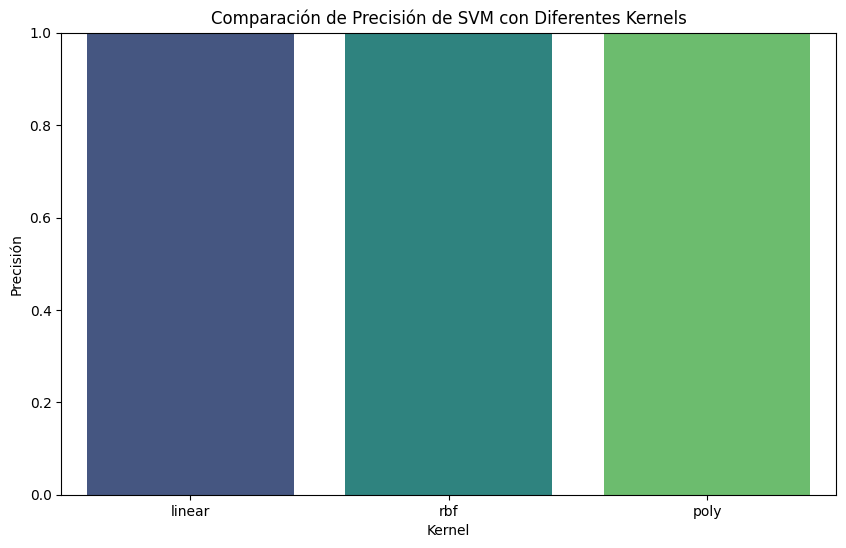

In [ ]:
# Extracción de precisión y nombres de kernels
accuracies = [result[1] for result in results]
kernel_names = [result[0] for result in results]

# Gráfico de barras para precisión
plt.figure(figsize=(10, 6))
sns.barplot(x=kernel_names, y=accuracies, palette='viridis')
plt.title('Comparación de Precisión de SVM con Diferentes Kernels')
plt.xlabel('Kernel')
plt.ylabel('Precisión')
plt.ylim(0, 1)  # Ajustar según sea necesario
plt.show()


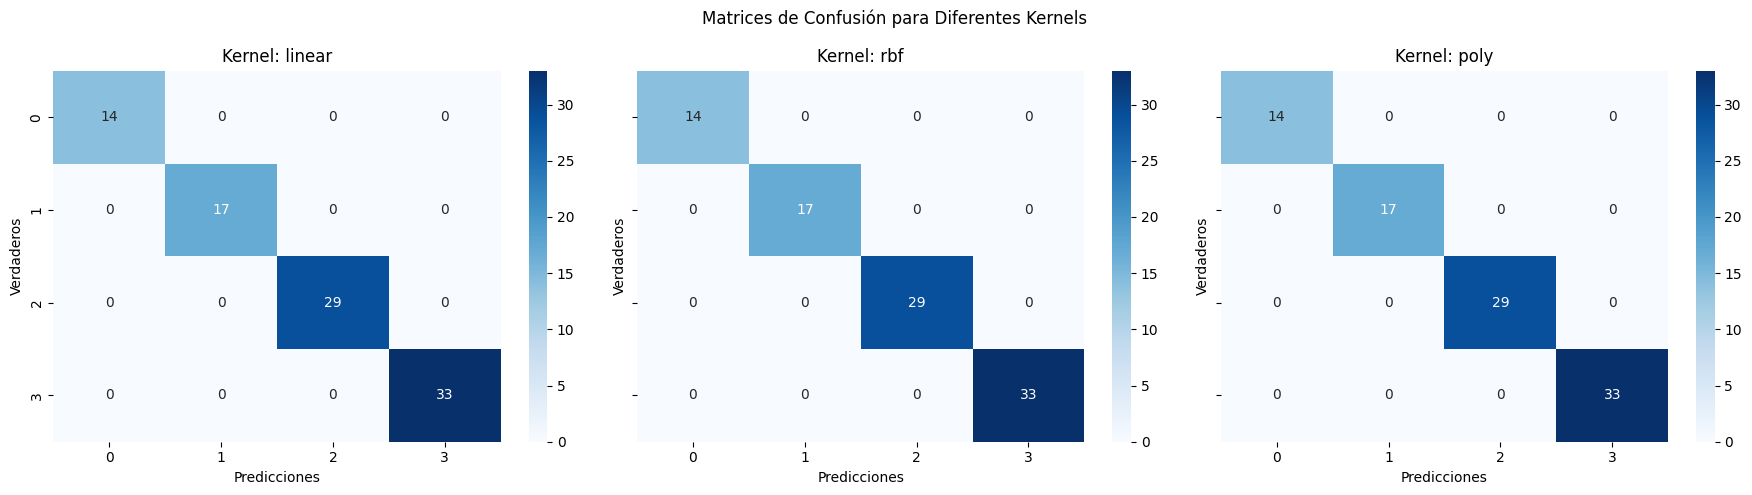

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Matrices de Confusión para Diferentes Kernels')

for i, conf_matrix in enumerate(confusion_matrices):
    ax = axes[i]
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax, cmap='Blues')
    ax.set_title(f'Kernel: {kernels[i]}')
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Verdaderos')

plt.tight_layout()


Establecemos el best Kernell como el lineal

In [ ]:
best_kernel = 'linear'

### EVALUACION DE LOS MODELOS

Para evaluar el modelo haremos lo que se nos solicita en este caso que es evaluarlo con imágenes que no estén ni en el test ni en el entrenamiento de tal forma que podamos observar como el modelo reacciona a nuevos datos.

In [ ]:
# Definir nuevas imágenes para validación (extracción de 10 imágenes adicionales)
validation_images = []
validation_labels = []

# Agregar nuevas imágenes y sus etiquetas a 'validation_images' y 'validation_labels'
# Asegúrate de que estas imágenes no estén ni en el conjunto de entrenamiento ni en el de test
for category in categories:
    folder_path = os.path.join(base_path, category)
    if os.path.exists(folder_path):
        # Extraer 10 imágenes diferentes para validación
        count = 0
        for file in os.listdir(folder_path):
            if count >= 10:  # Limitar a 10 imágenes
                break
            img_path = os.path.join(folder_path, file)
            if img_path not in X_train and img_path not in X_test:
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img)
                validation_images.append(img_array)
                validation_labels.append(label_encoder.transform([category]))
                count += 1

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# Evaluar con el modelo con mejor rendimiento (kernel 'linear', 'rbf' o 'poly')
best_kernel = 'linear'  # Cambiar según el mejor resultado
model = svm.SVC(kernel=best_kernel, gamma='scale')
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Entrenar con el mejor kernel

# Predecir las etiquetas de las nuevas imágenes
y_validation_pred = model.predict(validation_images.reshape(validation_images.shape[0], -1))

# Calcular precisión y matriz de confusión
validation_accuracy = accuracy_score(validation_labels, y_validation_pred)
validation_conf_matrix = confusion_matrix(validation_labels, y_validation_pred)

# Mostrar resultados
print(f"Precisión en imágenes de validación: {validation_accuracy}")
print("Matriz de confusión para imágenes de validación:")
print(validation_conf_matrix)


Precisión en imágenes de validación: 1.0
Matriz de confusión para imágenes de validación:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]


Finalmente, observamos como efectivamente los datos tienen una relación completamente lineal ya que con unos nuevos datos que no han sido observados el modelo ha conseguido un 100% de precisión.

# LAB 03 PRÁCTICA 4

##IMPORTACIÓN DE LIBRERÍAS

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


##TRATAMIENTO DE DATOS

Accedemos a la base de datos previamente guardada en Google Drive para trabajar con ella en nuestro Colab.

In [ ]:
# Especificar la ruta del archivo en tu Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/genes.csv' #poner ruta de guardado en drive

genes_df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Moatramos las primeras filas para ver la estructura de la base de datos.

In [ ]:
genes_df.head()

,Gene1,Gene2,CancerPresent
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


Se pueden ver más datos con esta matriz de confusión:

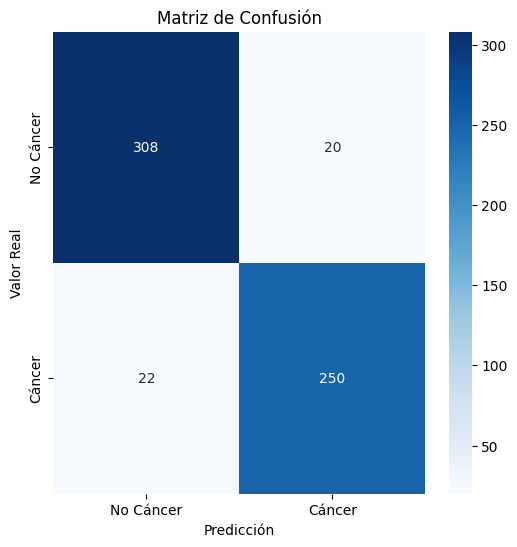

In [ ]:
# Visualizar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cáncer', 'Cáncer'], yticklabels=['No Cáncer', 'Cáncer'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

##EXPLICACIÓN

K-Nearest Neighbors (KNN) es un algoritmo de aprendizaje supervisado utilizado para tareas de clasificación y regresión que se basa en la proximidad. La idea es que los elementos que son similares entre sí tienden a pertenecer a la misma categoría o clase. Al clasificar una nueva instancia, KNN busca entre el conjunto de entrenamiento sus n_neighbors más cercanos y asigna la clase más frecuente entre ellos, donde la cercanía se determina mediante una métrica de distancia como la distancia euclidiana o de Manhattan.

En este ejercicio, KNN se aplicará para predecir la presencia de cáncer basándose en las características de dos genes, Gene1 y Gene2. El objetivo es entrenar un modelo KNN que pueda clasificar correctamente si una instancia pertenece a la clase "Cáncer" o "No Cáncer". Para lograrlo, se debe ajustar el número de vecinos utilizados para clasificar y la métrica de distancia que mide la proximidad entre las instancias.

##RESOLUCIÓN DEL EJERCICIO

Dividimos los datos con un 80% para entrenamiento y 20% para prueba.

In [ ]:
# Dividir el dataset para entrenamiento y prueba
X = genes_df[['Gene1', 'Gene2']]
y = genes_df['CancerPresent']
# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Dividir con un 80% para entrenamiento y 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Se toman ciertas decisiones:
- Número de Vecinos: Se prueba con 3, 5, 7, 9, y 11 para dar estabilidad. Números pequeños de vecinos pueden ser sensibles al ruido, mientras que números más grandes suelen ser más robustos.
- Métrica de Distancia: Se usa distancia euclidiana y de Manhattan para medir cercanía entre instancias. La distancia euclidiana es común y adecuada para datos en escala similar, mientras que la de Manhattan puede ser útil para estructuras con patrones de cuadrícula.
- Validación Cruzada: Se elige una validación cruzada de 5 pliegues para obtener un modelo más robusto y reducir el riesgo de sobreajuste.

In [ ]:
# Configurar el modelo KNN y la cuadrícula de búsqueda para diferentes configuraciones
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan']
}

# Crear el modelo KNN y aplicar GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  #5 pliegues
grid_search.fit(X_train, y_train)

# Obtener la mejor configuración y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluar el rendimiento del modelo con el conjunto de prueba
y_test_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Resultados
(best_params, best_score, test_accuracy)

({'metric': 'manhattan', 'n_neighbors': 11}, 0.9324999999999999, 0.93)

Se hace una gráfica con la evolución de la precisión según el número de vecinos y la métrica de distancia.

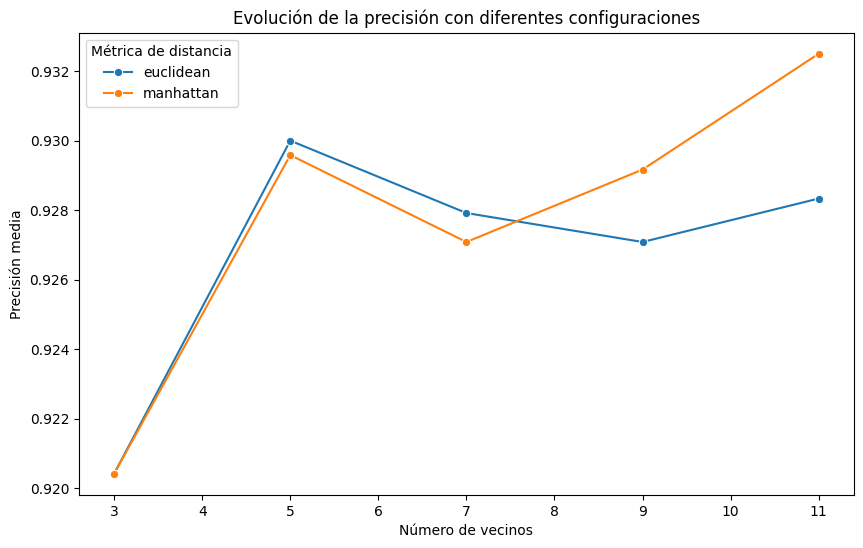

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_n_neighbors', y='mean_test_score', hue='param_metric', marker='o')
plt.title("Evolución de la precisión con diferentes configuraciones")
plt.xlabel("Número de vecinos")
plt.ylabel("Precisión media")
plt.legend(title="Métrica de distancia")
plt.show()


Para obtener la máxima precisión en el modelo KNN, la combinación de 11 vecinos con la métrica de distancia de Manhattan parece ser la más efectiva. Este resultado sugiere que utilizar más vecinos con esta métrica proporciona un modelo más robusto y con mayor precisión para la clasificación.

In [ ]:
# Configurar el clasificador KNN con la mejor combinación (11 vecinos y métrica de Manhattan)
best_knn = KNeighborsClassifier(n_neighbors=11, metric='manhattan')

# Entrenar el modelo con el conjunto de entrenamiento
best_knn.fit(X_train, y_train)

# Predecir valores del conjunto de prueba
y_test_pred = best_knn.predict(X_test)

# Evaluar la precisión y obtener el reporte de clasificación y la matriz de confusión para el conjunto de prueba
test_accuracy = accuracy_score(y_test, y_test_pred)  # Precisión del modelo
classification_rep = classification_report(y_test, y_test_pred)  # Reporte de clasificación
confusion = confusion_matrix(y_test, y_test_pred)  # Matriz de confusión

# Presentar resultados
{
    "Precisión del conjunto de prueba": test_accuracy,
    "Reporte de clasificación": classification_rep,
    "Matriz de confusión": confusion
}

{'Precisión del conjunto de prueba': 0.93,
 'Reporte de clasificación': '              precision    recall  f1-score   support\n\n           0       0.93      0.94      0.94       328\n           1       0.93      0.92      0.92       272\n\n    accuracy                           0.93       600\n   macro avg       0.93      0.93      0.93       600\nweighted avg       0.93      0.93      0.93       600\n',
 'Matriz de confusión': array([[308,  20],
        [ 22, 250]])}

La precisión del conjunto de prueba es 0.93 (93%). Esto significa que el modelo KNN clasifica correctamente el 93% de las instancias del conjunto de prueba. Una precisión alta sugiere que el modelo tiene un buen desempeño para predecir la clase correcta.
El reporte de clasificación muestra valores altos de precisión, recall y f1-score, y la matriz de confusión destaca las áreas donde el modelo puede mejorar, como los falsos positivos y falsos negativos.